# Inverse Desing of a Metalens: Intensity Optimizer

In the basic variant, we consider radially symmetric metalens ($r,z$ axes) and post-type meta-atoms (MAs). Space between a lens and focal plane is filled by air ($n^\textrm{med} = 1.0$ for all wavelengths in the range).

## definitions

$F$ - focal distance; upper index $^F$ means in the value in focal point or plane; 

$r_i$ - in-plane distance from optical axis to the center of $i$-th MA; $i = 0, \dots, N_r$ - index of a MA;

$\vec{\rho_i}$ and $H_i$ - shape parameters and total height of $i$-th MA, respectively;

$\lambda_l$ - wavelength in vacuum; $l = 0, \dots, N_\lambda$ - index of wavelength;

$n_{il}^\textrm{MA}(\vec{\rho_i},\lambda_l)$ and $n^\textrm{med} = 1.0$ - effective indices of $i$-th MA @ $\lambda_l$ and medium;

$k_{il}^\textrm{MA}(\vec{\rho_i},\lambda_l) = \frac{2 \pi n_{il}^\textrm{MA}(\vec{\rho_i},\lambda_l)}{\lambda_l}$ and $k_l^\textrm{med} = \frac{2\pi}{\lambda_l}$ - corresponding wavenumbers;

$r_\textrm{zd}$ - radial point with zero phase dispersion; $r_{\textrm{zd},q}$ if zone approach is applied, where $q$ is index of zone;

$A_{il}$ - amplitude of electric field at the output of $i$-th MA for $l$-th index of wavelength; $A_{il} = 1.0$ by default;

 ## main relations

Phase accumulated in $i$-th MA:

$$
\phi_{il}^\textrm{MA} (\lambda_l,\vec{\rho_i},H_i) = k_{il}^\textrm{MA}(\lambda_l,\vec{\rho_i}) H_i
$$

Phase accumulated in medium for radiation passed through $i$-th MA:

$$
\phi_{il}^\textrm{med} (\lambda_l, r_i, r_{\textrm{zd},q}) =
k_{il}^\textrm{med}(\lambda_l,\vec{\rho_i})
\left(
    \sqrt{ r_i^2 + F^2 } - \sqrt{ r_{\textrm{zd},q}^2 + F^2 }
\right)
$$

To construct "perfect" metalens phase dispersions produced by MAs and medium should compensate each other:

$$
\Delta \phi_{il}^\textrm{MA} (\lambda_l,\vec{\rho_i},H_i) = -\Delta \phi_{il}^\textrm{med} (\lambda_l, r_i, r_{\textrm{zd},q})
$$

Electric field and intensity at focal point for specific wavelength are:

$$
E_{l}^F = \sum_i A_{il} e^{i\left( \phi_{il}^\textrm{MA} + \phi_{il}^\textrm{med} \right)}, ~~~~ I_{l}^F = \left| E_{l}^F \right|^2
$$

In practice, phase dispersion space is limited by MA's free parameters (shape, height, material index) giving min/max possible phase dipersions ($\Delta\phi_{\min}^{\textrm{MA}}$ and $\Delta\phi_{max}^{\textrm{MA}}$, respectively), and the following inequality should be satisfied:

$$
\Delta\phi_{\min}^{\textrm{MA}} \leq -\Delta \phi_{il}^\textrm{med} (\lambda_l,r_i,r_{\textrm{zd},q}) \leq \Delta\phi_{max}^{\textrm{MA}},
$$

where $q$ is a number of zone.

We can rewrite the inequality in the following way **\[ineq. 1\]**:

$$
\left( \frac{\Delta\phi_{\max}^{\textrm{MA}}}{\Delta k^\textrm{med}} + \sqrt{r_{i,q}^2 + F^2} \right)^2 - F^2
~~\le~~
r_{\textrm{zd},q}^2
~~\le~~
\left( \frac{\Delta\phi_{\min}^{\textrm{MA}}}{\Delta k^\textrm{med}} + \sqrt{r_{i,q}^2 + F^2} \right)^2 - F^2
$$

This means, that for each $r_i$ there is a range of $r_\textrm{zd}$ than can be used [see https://doi.org/10.1126/science.aaf6644].

Using this inequality we can divide metalens by radial zones, each with own constant $r_{\textrm{zd},q}$, as shown in below figure.

![lens_zone.png](data/lens_zone.png)

## optimization task formulation

Intensity at focal point point/plane:

$$
I_l^F = \left| \sum_{i \in \Omega} A_{il} e^{i\left( \phi_{il}^\textrm{MA} + \phi_{il}^\textrm{med} \right)} \right|^2
$$

where $\Omega$ is an area of interest.

![lens_inverse.png](data/lens_inverse.png)

Objective function can be constructed in different ways, but here we are dealing with multi-objective task:
$$
\max_l \min \sum_{i \in \Omega}  I_{il},
$$

In other words, for each wavelength we calculates intensity in the focal point/plane, and then maximize the mininum value.

Optimization can be carried out for:

1. $\phi_0(r_i)$ and $\Delta\phi(r_i)$, where boundaries are $[-\infty,\infty]$ (as far as phase is periodic) and $[\Delta\phi_{\min}^{\textrm{MA}},\Delta\phi_{\max}^{\textrm{MA}}]$, respectively;

2. $r_{\textrm{zd}}(r_i)$, where boundaries are defined from **\[ineq. 1\]**;

3. $r_{\textrm{zd},q}(r_{i,q})$, where boundaries are defined from **\[ineq. 1\]**. Only this variant is implemented in the notebook.

## imports & initial parameters

In [1]:
import jax                                       # JAX is used for auto-differentiation, jit compiling, and code executing on GPU 
import jax.numpy as np                           # NumPy backend
import numpy as onp                              # original NumPy
import nlopt                                     # nonlinear optimization library
from scipy.interpolate import UnivariateSpline   # for PSF interpolation
import matplotlib.pyplot as plt                  # figures plotting

# jax.config.update('jax_platform_name', 'cpu')    # run on CPU
jax.config.update('jax_enable_x64', True)        # by default jax uses float32; this switch it to float64
print('JAX devices:', jax.devices())             # listing of available devices for computing
key = jax.random.PRNGKey(42)                     # initial pseudorandom key; to be updated each time when jax.random is used  

##### metalens parameters
F = 3000                                         # focal distance       [μm]
D = 3000                                         # max. diameter        [μm]
R = 0.5*D                                        # max. radius          [μm]
dr = 7                                           # period of meta-atoms [μm]

##### wavelength range
wl_min = 8.0                                     # min. wavelength [μm]
wl_max = 12.0                                    # max. wavelength [μm]
Nwl = 51                                         # number of wavelengths in the range
wl_range_inv = np.linspace(wl_max, wl_min, Nwl)  # !!! max to min order is essential
k_range = 2*np.pi / wl_range_inv   # !!! n_med = 1
dk = k_range.max() - k_range.min()               # max/min wavenumbers difference

##### phase dispersion space
dphi_MA_min = 3.9 * (2*np.pi)                    # min. possible phase dispersion [rad]
dphi_MA_max = 9.6 * (2*np.pi)                    # max. possible phase dispersion [rad]

##### lens plane grid
r_in = np.mgrid[0.5*dr:R:dr]                     # centers of meta-atoms
r_in_mirrored = np.concatenate([-r_in[::-1],
                                 r_in])          # mirrored r_in
Nr = r_in.size                                   # total number of meta-atoms 
A_in = np.ones_like(r_in)                        # amplitudes
A_in_mirrored = np.concatenate([A_in[::-1],
                                A_in])          # mirrored A_in

##### zones
r_sep = np.array([0,880,1000,1100,1200,1300,1350,1400,1450,1500])  # some r coordinates that separate zones
Nq = r_sep.size - 1                                                # number of zones

##### output frame for integration
r_out_int = np.mgrid[-12:13:1]
z_out_int = np.array([F])

##### output frame for plotting figures
r_out_ext = np.mgrid[-100:101:1]
z_out_ext = np.mgrid[F-200:F+201:2]

JAX devices: [gpu(id=0)]


## basic functions

In [2]:
def randkey():
    '''
    Generates new key for jax.random.
    '''
    global key
    _, key = jax.random.split(key)
    return key

def get_NA(F, R, n=1.0):
    '''
    Returns numerical aperture of a lens.
    '''
    return n*np.sin(np.arctan(R/F))

def get_phase_lens_from_r_zd(r_zd):
    '''
    Reconstruction of phase map from r_zd vector.
    '''
    assert r_zd.size == r_in.size, f'Size of r_zd ({r_zd.size}) should coincide with the size of r_in ({r_in.size}).'
    return k_range.reshape((Nwl,1)) * ( np.sqrt(np.asarray(r_zd)**2 + F**2) - np.sqrt(r_in**2 + F**2) )

def get_phase_lens_from_phi0_dphi(phi0_dphi):
    '''
    Reconstruction of phase map from (φ0;Δφ) vector.
    '''
    assert phi0_dphi.size == 2*r_in.size, 'Size of phi0_dphi = (φ0;Δφ) should be 2*r_in.'
    
    phi0, dphi = np.split(np.asarray(phi0_dphi),2)
    dfreq = np.diff(1./wl_range_inv)                  # frequency spacing
    dfreq_norm = dfreq[:,np.newaxis] / np.sum(dfreq)  # normalized frequency spacing; np.cumsum(dfreq_norm) = 1
    dphi_range = dphi * dfreq_norm
    phase_range = np.cumsum(np.vstack([phi0,dphi_range]), axis=0)
    
    return phase_range

def get_phi0_dphi(phase_range, plot=True, r_sep=None):
    '''
    Calculates φ0 and Δφ for a given phase map.
    '''
    phi0 = np.angle(np.exp(1j*phase_range[0]))
    # phi0 = phase_range[0]
    dphi = phase_range[-1] - phase_range[0]
    
    # φ0, Δφ plotting if needed
    if plot:
        fig, axs = plt.subplots(1,2,figsize=(7,2.5))
        axs[0].plot(r_in/1000, phi0/(2*np.pi))
        axs[0].set_xlabel('r [mm]')
        axs[0].set_ylabel('$\phi_0~/~2\pi$ [rad]')
        axs[0].set_xlim([r_in.min()/1000, r_in.max()/1000])
        axs[1].plot(r_in/1000, dphi/(2*np.pi))
        axs[1].set_xlabel('r [mm]')
        axs[1].set_ylabel('$\Delta\phi~/~2\pi$ [rad]')
        axs[1].set_xlim([r_in.min()/1000, r_in.max()/1000])
        if r_sep != None:
            [axs[0].axvline(x=r/1000, color='gray', ls='--', lw=1) for r in r_sep]
            [axs[1].axvline(x=r/1000, color='gray', ls='--', lw=1) for r in r_sep]
        fig.tight_layout()
    
    return phi0, dphi

def phase_propagator_rz(r, z):
    '''
    Calculates phases accumulated by meta-atoms when projecting electic field
    from (r_in,z=0) plane to (r,z) point
    '''
    return k_range.reshape((Nwl,1)) * np.sqrt((r_in_mirrored-r)**2 + z**2)

# vertorized variant of phase_propagator()
phase_propagator_rz_vmap = jax.vmap(phase_propagator_rz)

@jax.jit # !!! jit compiling accelerates calculations, but can be switched off
def get_Erz(phase_range, r_out=r_out_int, z_out=z_out_int):
    '''
    Calculates complex amplitides of the electic field in [r_out,z_out] plane.
    '''
    Nr_out, Nz_out = r_out.size, z_out.size
    R_out, Z_out = np.meshgrid(r_out, z_out, indexing='ij')
    R_out, Z_out = R_out.flatten(), Z_out.flatten()
    phase_range_mirrored = np.hstack([phase_range[:,::-1],phase_range])
    
    phase_tot = phase_range_mirrored + phase_propagator_rz_vmap(R_out, Z_out)
    amp_out = np.sum( A_in_mirrored*np.exp(1j*phase_tot), axis=2 ).T
    amp_out = amp_out.reshape((Nwl,Nr_out,Nz_out))
    
    return np.squeeze(amp_out) # !!! output is squeezed

# calculates intensity in [r_out,z_out] plane
get_Irz = lambda *args, **kwargs: np.abs(get_Erz(*args, **kwargs))**2

def get_r_zd_min(r):
    '''
    Calculates min. possible r_zd than can be used for a given radial point(s).
    '''
    return np.sqrt((dphi_MA_min/dk + np.sqrt(r**2+F**2))**2 - F**2)

def get_r_zd_max(r):
    '''
    Calculates max. possible r_zd than can be used for a given radial point(s).
    '''  
    return np.sqrt((dphi_MA_max/dk + np.sqrt(r**2+F**2))**2 - F**2)

def get_r_min(r_zd):
    '''
    Calculates min. possible r than can be used for a given r_zd.
    '''
    return np.sqrt((np.sqrt(r_zd**2+F**2) - dphi_MA_max/dk)**2 - F**2)

def get_r_max(r_zd):
    '''
    Calculates max. possible r than can be used for a given r_zd.
    '''
    return np.sqrt((np.sqrt(r_zd**2+F**2) - dphi_MA_min/dk)**2 - F**2)

def gen_r_sep(n, minval=0, maxval=R):
    '''
    Generates r_sep vector depending on the input.
    '''
    seps = jax.random.choice(
        randkey(),
        np.arange(minval,maxval-1), shape=(n-1,)
        ).sort()
    return np.concatenate([np.array([0]), seps, np.array([maxval])])

def find_r_zd_q(r_sep):
    '''
    Finds min/max r_zd_q in each zone defined by r_sep.
    '''
    Nq = r_sep.size - 1
    r_zd_q_min = np.array([ np.max(get_r_zd_min(r_sep[i:i+2])) for i in range(Nq) ])
    r_zd_q_max = np.array([ np.min(get_r_zd_max(r_sep[i:i+2])) for i in range(Nq) ])
    
    return r_zd_q_min, r_zd_q_max

def r_zd_q_to_r_zd(r_zd_q, r_sep):
    '''
    Transforms r_zd_q to r_zd.
    '''
    Nq = r_sep.size - 1
    # counting meta-atoms in each zone
    r_counts = np.array([ ((r_sep[i]<r_in)&(r_in<=r_sep[i+1])).sum() for i in range(Nq) ])
    r_zd = np.repeat(r_zd_q, r_counts)
    
    return r_zd

def get_FWHM(x, y):
    '''
    Finds FWHM for y(x). If more than 2 FWHM points are found returns NaN.
    '''
    if y.ndim == 1:
        spline = UnivariateSpline(x, y-0.5*np.max(y), s=0)
        roots = spline.roots()
        if len(roots) == 2:
            FWHM = roots[1] - roots[0]
        else:
            FWHM = np.nan
    elif y.ndim == 2:
        FWHM = list(map(lambda y: get_FWHM(x,y), y))
    else:
        print('Incorrect input.')
        return None
    
    return np.array(FWHM)

def plot_Irz_lens(r_out_ext, z_out_ext, Irz_lens, reduce=1):
    '''
    Intensity distributions plotting.
    '''
    N = Nwl//reduce
    fig, axs = plt.subplots(1,N,figsize=(N,3))
    for i in range(N): 
        axs[i].pcolormesh(r_out_ext/1000, z_out_ext/1000, Irz_lens[i*reduce].T)
        axs[i].axhline(y=F/1000, c='white', ls='--', lw=1)
        axs[i].set_title(f'λ = {wl_range_inv[i*reduce]:.2f} μm', fontsize='small')
        axs[i].set_aspect('equal')
        if i == 0:
            axs[i].set_xticks([r_out_ext.min()/1000, 0, r_out_ext.max()/1000])
            axs[i].tick_params(axis='both', which='major', labelsize='small')
            axs[i].set_xlabel('r [mm]')
            axs[i].set_ylabel('z [mm]')
        else:
            axs[i].axis('off')
    fig.tight_layout()

def plot_r_zd(r_zd_min, r_zd_max, r_zd_opt=None, r_sep=None, r_zd_q_min=None, r_zd_q_max=None):
    fig, ax = plt.subplots(1,1,figsize=(4,2.5))
    ax.plot(r_in/1000, r_zd_min/1000, label='$r_{zd}^{min}$')
    ax.plot(r_in/1000, r_zd_max/1000, label='$r_{zd}^{max}$')
    ax.fill_between(r_in/1000, r_zd_min/1000, r_zd_max/1000, color='gray', alpha=0.5)
    ax.set_xlabel('r [mm]')
    ax.set_ylabel('$r_{zd}$ [mm]')
    ax.set_xlim([r_in.min()/1000, r_in.max()/1000])
    if np.all(r_zd_opt != None):
        ax.plot(r_in/1000, r_zd_opt/1000, '.', ms=1.5, label='$r_{zd}^{opt}$')
    if r_sep != None:
        [ax.axvline(x=r/1000, color='gray', ls='--', lw=1) for r in r_sep]
    if r_zd_q_min != None:
        Nq = r_sep.size
        r_step = np.diff(r_sep)
        [ax.axhline(y=r_zd_q_min[i]/1000, xmin=float(r_sep[i]/R), xmax=float((r_sep[i]+r_step[i])/R), c='k') for i in range(Nq-1)]
    if r_zd_q_max != None:
        Nq = r_sep.size
        r_step = np.diff(r_sep)
        [ax.axhline(y=r_zd_q_max[i]/1000, xmin=float(r_sep[i]/R), xmax=float((r_sep[i]+r_step[i])/R), c='k') for i in range(Nq-1)]
    ax.legend(fontsize='small')
    fig.tight_layout()

def plot_PSF_FWHM(Irz_F_lens, Irz_F_opt):
    '''
    Plots PSF FWHM.
    '''
    PSF_FWHM_lens = get_FWHM(r_out_ext, Irz_F_lens)
    PSF_FWHM_opt  = get_FWHM(r_out_ext, Irz_F_opt)

    fig, ax = plt.subplots(1,1,figsize=(5,3))
    ax.plot(wl_range_inv, PSF_FWHM_lens, label='perfect')
    ax.plot(wl_range_inv, PSF_FWHM_opt, label='optimized')
    ax.set_xlim([wl_range_inv.min(), wl_range_inv.max()])
    ax.set_xlabel('$\lambda$ [μm]')
    ax.set_ylabel('PSF FWHM [μm]')
    ax.legend()
    fig.tight_layout()


## perfect metalens

Metalens:
------------------
Design parameters: F=3.0 mm, D=3.0 mm, NA=0.45
Wavelength range: [8.0,12.0] μm
Number of wavelengths in the range: 51
Required phase dispersion: 14.65 × 2π.
Total number of meta-atoms: 214.


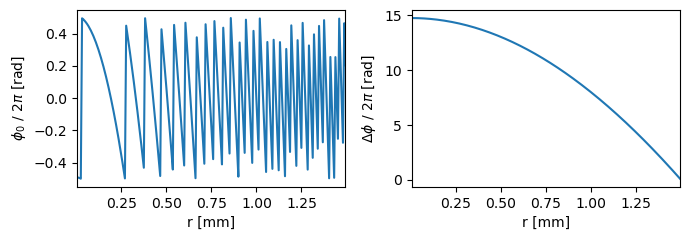

In [3]:
r_zd = R*np.ones(Nr)                              # let r_zd = R, but any number can be chosen
phase_lens = get_phase_lens_from_r_zd(r_zd)       # phase map for a lens with constant r_zd
phi0_lens, dphi_lens = get_phi0_dphi(phase_lens)  # corresponding φ0, Δφ

# lens info
print('Metalens:',
      '------------------',
      f'Design parameters: F={F/1000} mm, D={D/1000} mm, NA={get_NA(F,R):.2f}',
      f'Wavelength range: [{wl_range_inv.min()},{wl_range_inv.max()}] μm',
      f'Number of wavelengths in the range: {Nwl}',
      f'Required phase dispersion: {(dphi_lens.max()-dphi_lens.min())/(2*np.pi):.2f} × 2π.',
      f'Total number of meta-atoms: {Nr}.', sep='\n')

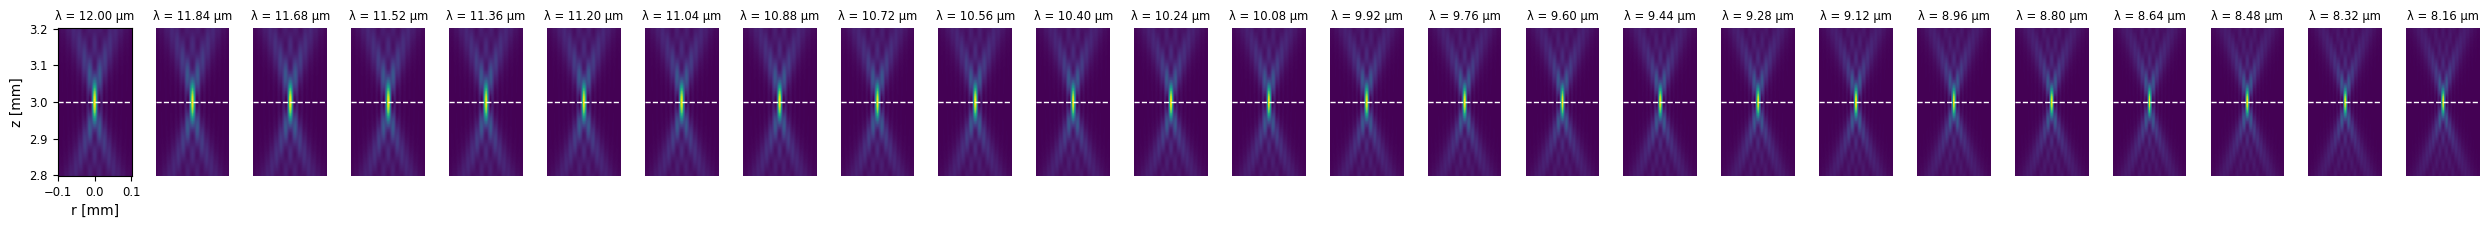

In [4]:
# intensity distrubution for a perfect lens
Irz_lens = get_Irz(phase_lens, r_out_ext, z_out_ext)

# intensity distribution near focal point for a perfect metalens
plot_Irz_lens(r_out_ext, z_out_ext, Irz_lens, reduce=2)

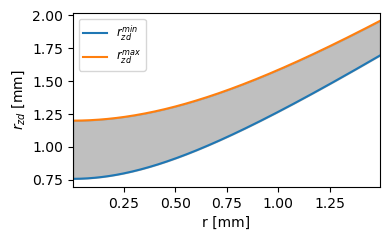

In [5]:
# r_zd_min, r_zd_max for all meta-atoms
r_zd_min = get_r_zd_min(r_in)
r_zd_max = get_r_zd_max(r_in)

plot_r_zd(r_zd_min, r_zd_max)

Min/max radii for defined r_zd: 870.35, 1277.06 μm.


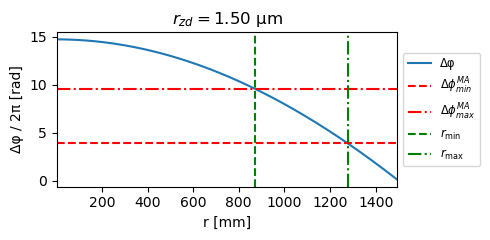

In [6]:
# r_min, r_max for a constant (!!!) r_zd
r_min = get_r_min(r_zd[0])
r_max = get_r_max(r_zd[0])
print(f'Min/max radii for defined r_zd: {r_min:.2f}, {r_max:.2f} μm.')

fig, ax = plt.subplots(1,1,figsize=(5,2.5))
ax.plot(r_in, dphi_lens / (2*np.pi), label='Δφ')
ax.axhline(y=dphi_MA_min / (2*np.pi), ls='--', c='red', label='$\Delta\phi_{min}^{MA}$')
ax.axhline(y=dphi_MA_max / (2*np.pi), ls='-.', c='red', label='$\Delta\phi_{max}^{MA}$')
ax.axvline(x=r_min, ls='--', c='green', label='$r_{\min}$')
ax.axvline(x=r_max, ls='-.', c='green', label='$r_{\max}$')
ax.set_title('$r_{zd} = $'+f'{r_zd[0]/1000:.2f} μm')
ax.set_xlim([r_in.min(), r_in.max()])
ax.set_xlabel('r [mm]')
ax.set_ylabel('Δφ / 2π [rad]')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')
fig.tight_layout()

## optimization: $r_{\textrm{zd},q}$ is free parameter (radial zones)

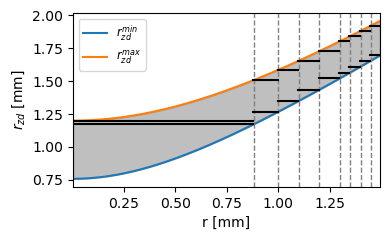

In [7]:
# finding and plotting zones
r_zd_q_min, r_zd_q_max = find_r_zd_q(r_sep)
plot_r_zd(r_zd_min, r_zd_max, r_sep=r_sep, r_zd_q_min=r_zd_q_min, r_zd_q_max=r_zd_q_max)

In [8]:
# intensity integrated in Ω = [r_out_int, F]
Irz_lens_int = np.sum( get_Irz(phase_lens), axis=1 )

def J_int(r_zd_q):
    '''
    Objective function for optimization is maxmin(I_l).
    '''
    r_zd = r_zd_q_to_r_zd(r_zd_q,r_sep)
    phase_range = get_phase_lens_from_r_zd(r_zd)
    Irz_int = np.sum( get_Irz(phase_range), axis=1 ) / Irz_lens_int
    
    return np.min(Irz_int)

J_int_grad = jax.grad(J_int)   # calculates gradient for the objective function

J_int(r_zd_q_min), J_int_grad(r_zd_q_min); # test run

In [9]:
counter = 0
J_hist = []

def nlopt_func(r_zd_q, grad):
    
    global counter, J_hist
    
    y = float(J_int(r_zd_q))
    if grad.size > 0:
        grad[:] = onp.array(J_int_grad(r_zd_q)).tolist()
    
    counter += 1
    J_hist.append(np.copy(y))
    print(f'step # {counter:3}, J = {y:.3f}', end='\r',flush=True)
    
    return y

r_zd_q_mid = 0.5 * (r_zd_q_min + r_zd_q_max)
r_zd_q_amp = r_zd_q_max - r_zd_q_min
noise = 0.1 * (0.5-jax.random.uniform(randkey(),(Nq,))) # [-1,1] value
r_zd_q_init = r_zd_q_mid + r_zd_q_amp*noise

opt = nlopt.opt(nlopt.LD_LBFGS, Nq)
opt.set_lower_bounds(r_zd_q_min)
opt.set_upper_bounds(r_zd_q_max)
opt.set_xtol_rel(1e-9)
opt.set_maxeval(999)
opt.set_max_objective(nlopt_func)

r_zd_q_opt = opt.optimize(r_zd_q_init)

print(f'\nBest J = {max(J_hist):.3f}')

step #  55, J = 0.498
Best J = 0.498


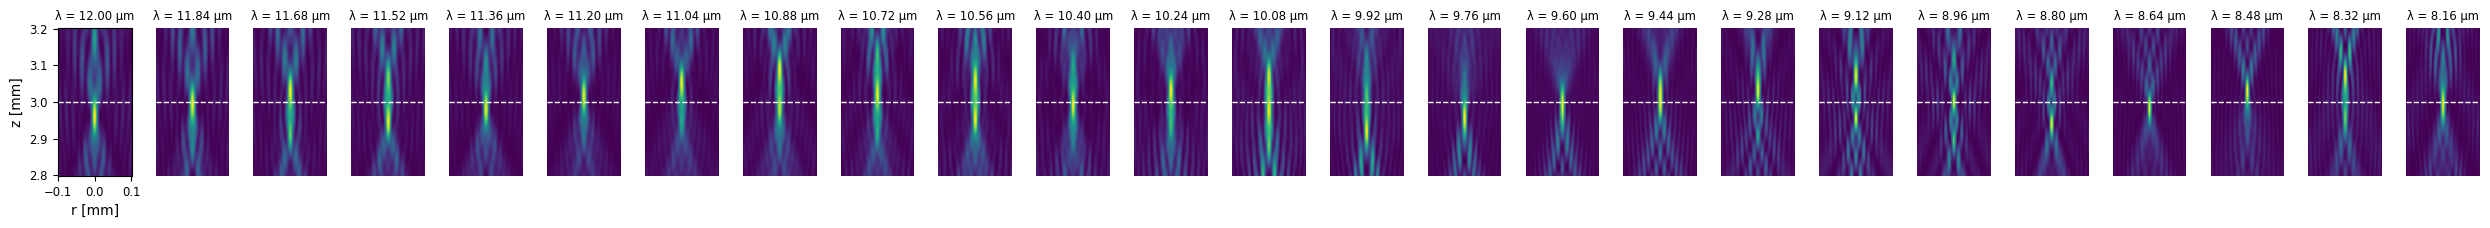

In [10]:
r_zd_opt = r_zd_q_to_r_zd(r_zd_q_opt,r_sep)
phase_opt = get_phase_lens_from_r_zd(r_zd_opt)
Irz_opt = get_Irz(phase_opt, r_out_ext, z_out_ext)

plot_Irz_lens(r_out_ext, z_out_ext, Irz_opt, reduce=2)

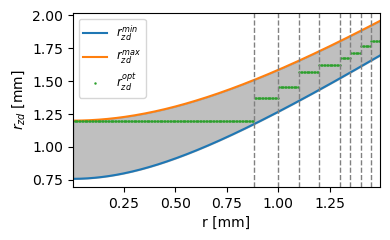

In [11]:
plot_r_zd(r_zd_min, r_zd_max, r_zd_opt, r_sep=r_sep)

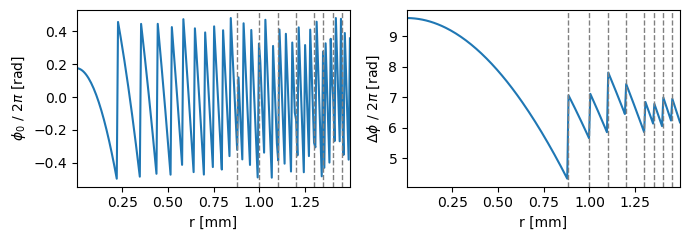

In [12]:
get_phi0_dphi(phase_opt, r_sep=r_sep);

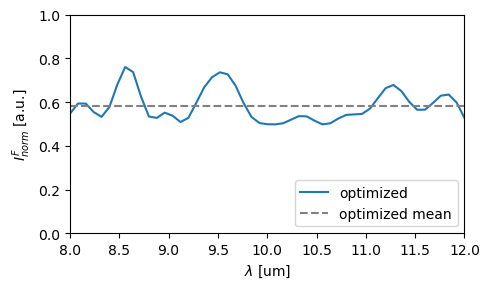

In [13]:
# plotting I_Ω^opt / I_Ω^lens
Irz_lens_int = np.sum(get_Irz(phase_lens), axis=1)
Irz_opt_int  = np.sum(get_Irz(phase_opt),  axis=1)
Irz_opt_int_norm = Irz_opt_int / Irz_lens_int

fig, ax = plt.subplots(1,1,figsize=(5,3))
ax.plot(wl_range_inv, Irz_opt_int_norm, label='optimized')
ax.axhline(y=Irz_opt_int_norm.mean(), ls='--', c='grey', label='optimized mean')
ax.set_xlim([wl_range_inv.min(), wl_range_inv.max()])
ax.set_ylim([0, 1])
ax.set_xlabel('$\lambda$ [um]')
ax.set_ylabel('$I_{norm}^F$ [a.u.]')
ax.legend(loc='lower right')
fig.tight_layout()

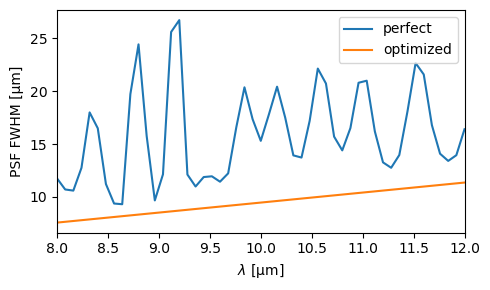

In [14]:
Irz_F_lens = get_Irz(phase_lens, r_out=r_out_ext)
Irz_F_opt  = get_Irz(phase_opt,  r_out=r_out_ext)

plot_PSF_FWHM(Irz_F_opt, Irz_F_lens)

#### 3D propagation (zones on XY grid)

In [15]:
##### XY grid
X_in, Y_in = np.mgrid[-(R//dr)*dr+0.5*dr:R:dr,-(R//dr)*dr+0.5*dr:R:dr]
R_in = np.sqrt(X_in**2 + Y_in**2)
R_zd = R
A_in = np.zeros_like(R_in)
A_in = A_in.at[R_in<R].set(1.)

##### output grid
x_out_ext = y_out_ext = np.mgrid[-100:100:51j]
z_out_ext = np.array([F])

##### phase map for a perfect lens
phase_lens_xy = k_range.reshape((Nwl,1,1)) * ( np.sqrt(R_zd**2 + F**2) - np.sqrt(R_in**2 + F**2) )

In [16]:
def phase_propagator_xyz(x,y,z):
    dx = np.abs(X_in-x)                 # in-plane shift along x-axis
    dy = np.abs(Y_in-y)                 # in-plane shift along y-axis
    dz = z                              # shift along z-axis
    D = np.sqrt(dx**2+dy**2+dz**2)      # total distance
    return k_range.reshape((Nwl,1,1)) * D

phase_propagator_xyz_vmap = jax.vmap(phase_propagator_xyz)

@jax.jit
def get_Exyz(phase_range: np.ndarray,
             x_out:       np.ndarray = x_out_ext,
             y_out:       np.ndarray = y_out_ext,
             z_out:       np.ndarray = z_out_ext
             ) -> np.ndarray:
    
    Nx_out, Ny_out, Nz_out = x_out.size, y_out.size, z_out.size
    X_out, Y_out, Z_out  = np.meshgrid(x_out, y_out, z_out, indexing='ij')
    X_out, Y_out, Z_out = X_out.flatten(), Y_out.flatten(), Z_out.flatten()
    
    phase_tot = phase_range + phase_propagator_xyz_vmap(X_out,Y_out,Z_out)
    amp_out = np.sum( A_in*np.exp(1j*phase_tot), axis=(2,3) ).T
    amp_out = amp_out.reshape((Nwl,Nx_out,Ny_out,Nz_out))
    
    return np.squeeze(amp_out)

get_Ixyz = lambda *args, **kwargs: np.abs(get_Exyz(*args, **kwargs))**2

Ixy_F_lens = get_Ixyz(phase_lens_xy)

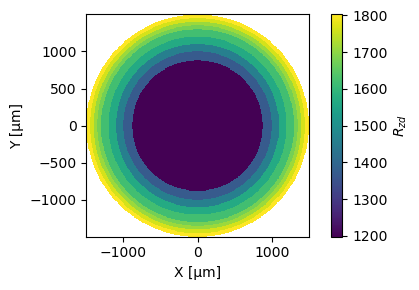

In [26]:
R_zd_opt_xy = np.zeros_like(R_in)

for i in range(Nq):
    mask = (r_sep[i] < R_in) & (R_in <= r_sep[i+1])
    R_zd_opt_xy = R_zd_opt_xy.at[mask].set(r_zd_q_opt[i])

fig, ax = plt.subplots(1,1,figsize=(5,3))
c = ax.pcolormesh(X_in, Y_in, np.where(R_zd_opt_xy!=0, R_zd_opt_xy, np.nan))
fig.colorbar(c, ax=ax).set_label('$R_{zd}$')
ax.set_aspect('equal')
ax.set_xlabel('X [μm]')
ax.set_ylabel('Y [μm]')
fig.tight_layout()

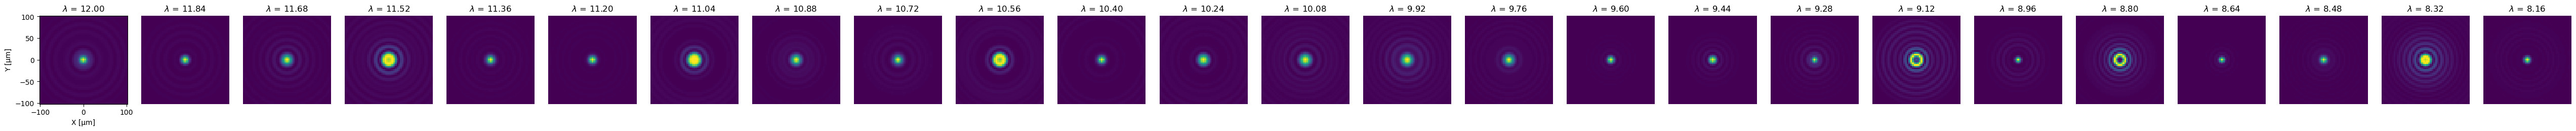

In [32]:
phase_opt_xy = k_range.reshape((Nwl,1,1)) * ( np.sqrt(R_zd_opt_xy**2 + F**2) - np.sqrt(R_in**2 + F**2) )

Ixy_F_opt = get_Ixyz(phase_opt_xy)

reduce = 2
fig, axs = plt.subplots(1,Nwl//reduce,figsize=(2*Nwl//reduce,2.5))
for i, ax in enumerate(axs):
    ax.pcolormesh(x_out_ext, y_out_ext, Ixy_F_opt[i*reduce])
    ax.set_aspect('equal')
    ax.set_title(f'$\lambda$ = {wl_range_inv[i*reduce]:.2f}')
    ax.set_xlabel('X [μm]')
    ax.set_ylabel('Y [μm]')
    if i > 0:
        ax.axis('off')
fig.tight_layout()

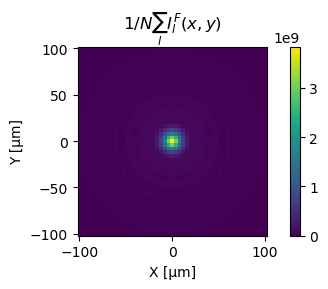

In [30]:
Ixy_F_opt_mean = np.mean(Ixy_F_opt, axis=0)

fig, ax = plt.subplots(1,1,figsize=(5,3))
c = ax.pcolormesh(x_out_ext, y_out_ext, Ixy_F_opt_mean, vmin=0)
fig.colorbar(c, ax=ax) #.set_label('$1/N \sum_l I_{l}^F(x,y)$')
ax.set_aspect('equal')
ax.set_title('$1/N \sum_l I_{l}^F(x,y)$')
ax.set_xlabel('X [μm]')
ax.set_ylabel('Y [μm]')
fig.tight_layout()

In [31]:
get_FWHM(x_out_ext, Ixy_F_opt_mean[x_out_ext.size//2,:])

Array(14.14511859, dtype=float64)